In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".15"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from scipy.interpolate import griddata
import flowrec.training_and_states as state_utils
import flowrec.losses as losses
import utils.simulation2d as project
import flowrec.data as data_utils

import jax
import jax.numpy as jnp
import optax
import haiku as hk

In [2]:
# train_test_split = [70,20,10]
train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [31] # size of the intermediate layers
cnn_channels = [31,3]
cnn_filter = [(3,3)]
dropout_rate = 0.02
regularisation_strength = 0.0001
epochs = 10
nb_batches = 6
data_dir = Path("./local_data/re100")
# data_dir = Path("/home/ym917/Results/simulations/triangle")

In [3]:
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
x = np.stack([ux,uy,pp],axis=0)
# use only a subset of data for test
x = x[:,:,:250,:]

[x_train,x_val,x_test], _ = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=False,SHUFFLE=False)
# [x_train,x_val,x_test], [xm_train,xm_val,xm_test] = data_utils.data_partition(x,1,train_test_split,REMOVE_MEAN=True,SHUFFLE=False)

[ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
[ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
[ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))


triangle_base_coords = [49,80]
pb_train = project.take_measurement_base(pp_train,ly=triangle_base_coords,centrex=0)
pb_val = project.take_measurement_base(pp_val,ly=triangle_base_coords,centrex=0)
pb_test = project.take_measurement_base(pp_test,ly=triangle_base_coords,centrex=0)

u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)


(nt,nx,ny) = ux_train.shape
n_base = pb_train.shape[-1]

mlp_layers.extend([3*nx*ny])

dx = 12/512
dy = 4/128
dt = 0.0002*625

datainfo = data_utils.DataMetadata(re=100,discretisation=[dt,dx,dy],axis_index=[0,1,2],problem_2d=True)


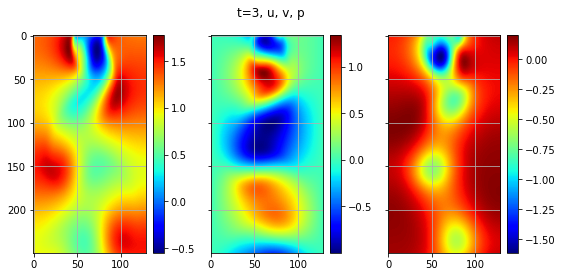

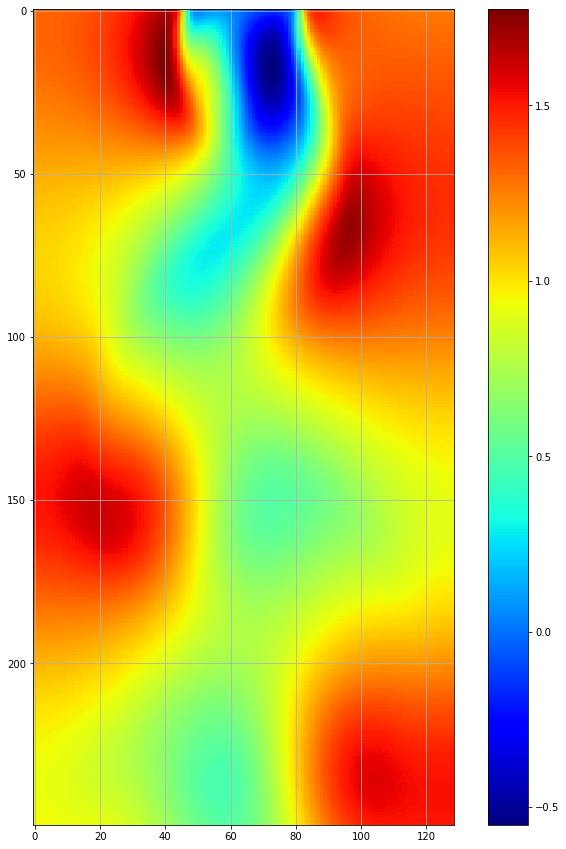

In [4]:
fig,axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=(9,4))
plt_t = 3
for i,ax in enumerate(axes):
    im = ax.imshow(x_train[i,plt_t,...],'jet')
    im = plt.colorbar(im,ax=ax)
    ax.grid('both')
fig.suptitle(f't={plt_t}, u, v, p')
plt.show()
plt.figure(figsize=(12,15))
plt.imshow(x_train[0,plt_t,...],'jet')
plt.colorbar()
plt.grid('both')
plt.show()

In [12]:
loss_true_div = losses.divergence(ux_train,uy_train,datainfo)
loss_true_mom_x = np.mean(losses.momentum_residue_field(1,ux_train,uy_train,pp_train,datainfo)**2)
loss_true_mom_y = np.mean(losses.momentum_residue_field(2,ux_train,uy_train,pp_train,datainfo)**2)
print(f'loss_div of data is {loss_true_div}, loss_moment of data is {loss_true_mom_x+loss_true_mom_y}')

loss_div of data is 4.047017500852235e-05, loss_moment of data is 0.008336953818798065


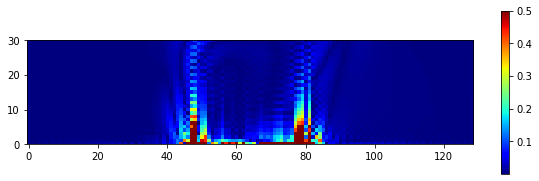

In [6]:
true_mom_x = losses.momentum_residue_field(1,ux_train,uy_train,pp_train,datainfo)
true_mom_y = losses.momentum_residue_field(2,ux_train,uy_train,pp_train,datainfo)
fig = plt.figure(figsize=(10,3))
plt.imshow(np.abs(true_mom_x+true_mom_y)[3,...],'jet',vmax=0.5)
plt.ylim([0,30])
plt.colorbar()
plt.show()

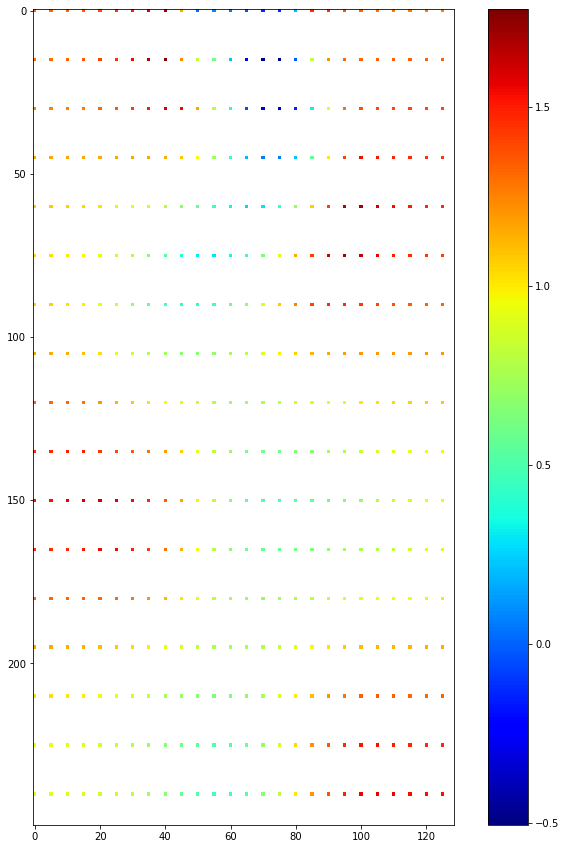

In [7]:
sensor_slicing_space = np.s_[::15,::5]
sensor_slicing = (np.s_[:],) + sensor_slicing_space

observed_ux = np.empty_like(ux_train)
observed_ux.fill(np.nan)
observed_ux[sensor_slicing] = ux_train[sensor_slicing]
observed_uy = np.empty_like(uy_train)
observed_uy.fill(np.nan)
observed_uy[sensor_slicing] = uy_train[sensor_slicing]
observed_pp = np.empty_like(pp_train)
observed_pp.fill(np.nan)
observed_pp[sensor_slicing] = pp_train[sensor_slicing]
observed_train = np.stack((observed_ux,observed_uy,observed_pp),axis=-1)



plt.figure(figsize=(12,15))
plt.imshow(observed_ux[3,...],'jet')
plt.colorbar()
plt.show()

In [8]:
def loss_fn(data,y,e=0.0001,**kwargs):
    # pred = apply_fn(params, rng, x, **kwargs)
    loss_div = losses.divergence(data[...,0], data[...,1], datainfo)
    loss_mom_x = jnp.mean(losses.momentum_residue_field(
                            1,
                            ux=data[...,0],
                            uy=data[...,1],
                            p=data[...,2],
                            datainfo=datainfo)**2
                            )
    loss_mom_y = jnp.mean(losses.momentum_residue_field(
                            2,
                            ux=data[...,0],
                            uy=data[...,1],
                            p=data[...,2],
                            datainfo=datainfo)**2
                            )
    loss_sensor = losses.mse(data[sensor_slicing], y)

    return jax.nn.relu(loss_div+loss_mom_x+loss_mom_y-e) + loss_sensor, (loss_div,loss_mom_x+loss_mom_y,loss_sensor)

In [9]:
l,(l_d,l_m,l_s) = loss_fn(u_train[400:500,...],observed_train[sensor_slicing][400:500,...],0.01)
print(l,l_d,l_m,l_s)

0.0 4.051177e-05 0.008575323 0.0


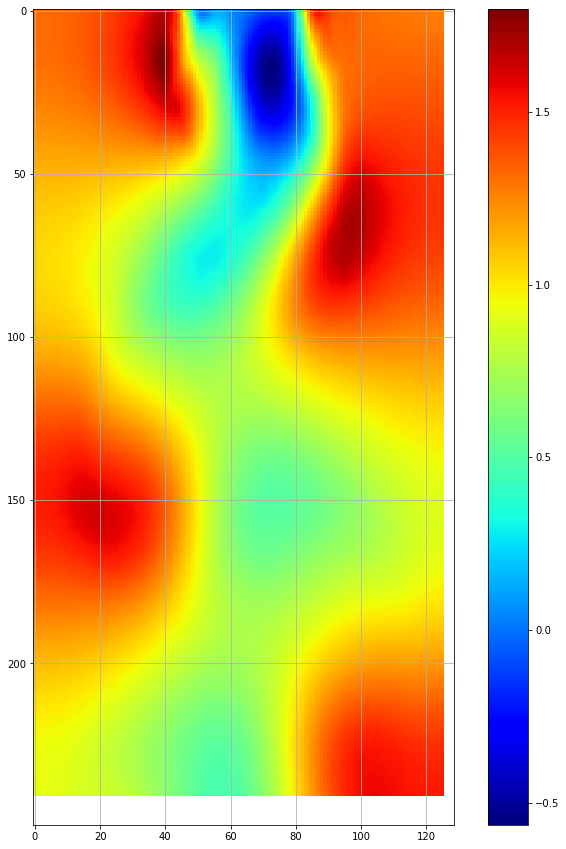

In [10]:
grid_x,grid_y = np.mgrid[0:observed_ux.shape[1], 0:observed_ux.shape[2]]
sensors_loc_x = grid_x[sensor_slicing_space]
sensors_loc_y = grid_y[sensor_slicing_space]
sensors_loc = np.stack((sensors_loc_x.flatten(),sensors_loc_y.flatten()),axis=-1)
data_interp = griddata(sensors_loc, observed_ux[(np.s_[3],)+sensor_slicing_space].flatten(), (grid_x,grid_y), method='cubic')
plt.figure(figsize=(12,15))
plt.imshow(data_interp,'jet')
plt.colorbar()
plt.grid('both')
plt.show()